# Post Regrid Data Handling

Goal is to have a streamlined way to access the files a user needs given a set of parameters. Envisioning something where a user could enter:
* Sectors of interest (or "all")
* Timerange of interest
* Spatial bounding box
* Gas species of interest    

And be returned either an xarray object with dask parallelization, or create a new netCDF/set of netCDF files to be loaded by the user later. 

There is obviously lots of work to be done, but this is a good start if you want to start playing with data. 


In [1]:
import xarray as xr
import pandas as pd
import os
import pyproj
import numpy as np
import xesmf as xe
import calendar
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

import noaa_csl_funcs as ncf

In [2]:
map_extent={'lon_min':-112.4,
            'lon_max':-111.4,
            'lat_min':40.1,
            'lat_max':41.3} 
dataset_extent = {'lon_min':-112.25,
                  'lon_max':-111.6,
                  'lat_min':40.3,
                  'lat_max':41.1} 

# Load from regridded

In [ ]:
regrid_id = 2
regridded_path = f'/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded{regrid_id}'
RCH = ncf.Regridded_CSL_Handler(regridded_path)
dt1  = pd.to_datetime('2019-01-01 00') 
dt2 = pd.to_datetime('2019-12-31 23') 
day_types = ['weekdy','satdy','sundy'] #a list with any or all of 'weekdy','satdy','sundy'
species = ['HC01','CO2','CO']

save_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC'
save_prefix = f'slc_2019_em27_{regrid_id}'

In [ ]:
sector_types = ['area','point']
combined_dss = {}
for sector_type in sector_types:
    #Get the paths to the files that match the criteria
    days_paths = RCH.get_days_in_range(dt1,dt2,day_types,sector_type) 
    files = RCH.get_files_in_days(days_paths)

    load_vars = [] #the variables we want to load
    if sector_type == 'area': #for area sources, just load the species defined above
        load_vars = species.copy() 
    if sector_type == 'point': #for point, often useful to have the stack/type information 
        load_vars = species.copy()
        load_vars.extend(['ITYPE','STKht','STKdiam','STKtemp','STKve','STKflw','FUGht']) #so add it to the actual species

    #Load the files with xarray, preprocessing them so they can be combined by coordinates
    ds_list = [] #initialize the list of datasets
    for file in files:
        ds = RCH.preprocess_regridded(xr.open_dataset(file,chunks = {'utc_hour':1}),dataset_extent)[load_vars] #prepreprocess the file, open with dask chunking, and only keep the species of interest
        ds_list.append(ds)  
    ds_combined = xr.combine_by_coords(ds_list,combine_attrs='drop_conflicts') #this is the combined dataset!
    combined_dss[sector_type] = ds_combined

In [ ]:
#Save to nc
for sector_type in sector_types:
    combined_dss[sector_type].to_netcdf(os.path.join(save_path,f"{save_prefix}_{sector_type}.nc"))

# Load from presaved

In [41]:
regrid_id = 2
regridded_path = f'/uufs/chpc.utah.edu/common/home/lin-group9/agm/NOAA_CSL_Data/regridded{regrid_id}'
RCH = ncf.Regridded_CSL_Handler(regridded_path)
day_types = ['weekdy','satdy','sundy'] #a list with any or all of 'weekdy','satdy','sundy'

save_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/NC'
save_prefix = f'slc_2019_em27_{regrid_id}'

#Load from nc
sector_types = ['area','point']
combined_dss = {}
for sector_type in sector_types:
    combined_dss[sector_type] = xr.load_dataset(os.path.join(save_path,f"{save_prefix}_{sector_type}.nc"))

In [42]:
area_ds = combined_dss['area']
day_sum_ds = xr.combine_by_coords([
    area_ds[spec].sum(dim='utc_hour').assign_attrs(
        {'units': f"{area_ds[spec].attrs['units'].split()[0]} day^-1 meters^-2"}
    ) 
    for spec in area_ds.data_vars
    ])

month_sums = []
for yr_mo in day_sum_ds.yr_mo.values:
    yr = int(yr_mo.split('-')[0]) #get the year int
    mo = int(yr_mo.split('-')[1]) #get the mnoth int
    sat,sun,wkdy = ncf.ncount_satsunwkd(yr,mo) #for that year and month, get the number of saturdays, sundays, and weekdays
    sat_sum = (day_sum_ds.sel(yr_mo=yr_mo,day_type='satdy')*sat).reset_coords('day_type',drop=True)#.assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
    sun_sum = (day_sum_ds.sel(yr_mo=yr_mo,day_type='sundy')*sun).reset_coords('day_type',drop=True)#.assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
    wkdy_sum = (day_sum_ds.sel(yr_mo=yr_mo,day_type='weekdy')*wkdy).reset_coords('day_type',drop=True)#.assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
    #wkdy_sum
    month_sum = sat_sum + sun_sum + wkdy_sum
    for var in day_sum_ds.data_vars:
        mass_unit = day_sum_ds[var].attrs['units'].split()[0]
        month_sum[var].attrs.update({'units':f'{mass_unit} month^-1 m^-2'})
    month_sums.append(month_sum)#.reset_coords('yr_mo',drop=True))

yr_sum = xr.concat(month_sums,dim='yr_mo').sum(dim='yr_mo')
for var in yr_sum.data_vars:
    mass_unit = month_sums[0][var].attrs['units'].split()[0]
    yr_sum[var].attrs.update({'units':f'{mass_unit} yr^-1 m^-2'})

In [43]:
grid_area = xr.open_dataset(f'../regridding/grid_area/grid_out_area{regrid_id}.nc')  #load the gridcell area file
grid_area = ncf.slice_extent(grid_area,dataset_extent) #slice it to the same extent
absolute_emissions = (yr_sum * grid_area['cell_area'])#.assign_attrs({'units':mass_unit}) #multiply by the yearsum

for var in yr_sum.data_vars:
    mass_unit = yr_sum[var].attrs['units'].split()[0]
    absolute_emissions[var].attrs.update({'units':f'{mass_unit} yr^-1 gridcell-1'})

absolute_emissions['HC01'] = (absolute_emissions['HC01']*16.04/1E6).assign_attrs({'units':'metric_Ton yr^-1 gridcell^-1'})

In [57]:
species = ['HC01','CO2','CO']

point_ds = combined_dss['point']
day_sum_ds = xr.combine_by_coords([
    point_ds[spec].sum(dim='utc_hour').assign_attrs(
        {'units': f"{point_ds[spec].attrs['units'].split()[0]} day^-1"}
    ) 
    for spec in species
    ])

month_sums = []
for yr_mo in day_sum_ds.yr_mo.values:
    yr = int(yr_mo.split('-')[0]) #get the year int
    mo = int(yr_mo.split('-')[1]) #get the mnoth int
    sat,sun,wkdy = ncf.ncount_satsunwkd(yr,mo) #for that year and month, get the number of saturdays, sundays, and weekdays
    sat_sum = (day_sum_ds.sel(yr_mo=yr_mo,day_type='satdy')*sat).reset_coords('day_type',drop=True)#.assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
    sun_sum = (day_sum_ds.sel(yr_mo=yr_mo,day_type='sundy')*sun).reset_coords('day_type',drop=True)#.assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
    wkdy_sum = (day_sum_ds.sel(yr_mo=yr_mo,day_type='weekdy')*wkdy).reset_coords('day_type',drop=True)#.assign_attrs({'units':f'{mass_unit} month^-1 meters^-2'})
    #wkdy_sum
    month_sum = sat_sum + sun_sum + wkdy_sum
    for var in day_sum_ds.data_vars:
        mass_unit = day_sum_ds[var].attrs['units'].split()[0]
        month_sum[var].attrs.update({'units':f'{mass_unit} month^-1'})
    month_sums.append(month_sum)#.reset_coords('yr_mo',drop=True))

yr_sum = xr.concat(month_sums,dim='yr_mo').sum(dim='yr_mo')
for var in yr_sum.data_vars:
    mass_unit = month_sums[0][var].attrs['units'].split()[0]
    yr_sum[var].attrs.update({'units':f'{mass_unit} year^-1'})

yr_sum['HC01'] = (yr_sum['HC01']*16.04/1E6).assign_attrs({'units':'metric_Ton yr^-1'})

In [69]:
for sector in yr_sum['sector']:
    print(sector,':',yr_sum.sel(sector=sector)['HC01'].max().values)

<xarray.DataArray 'sector' ()>
array('point_EGU', dtype='<U9')
Coordinates:
    sector   <U9 'point_EGU' : 69.77623748779297
<xarray.DataArray 'sector' ()>
array('point_Industry', dtype='<U14')
Coordinates:
    sector   <U14 'point_Industry' : 73.19071197509766
<xarray.DataArray 'sector' ()>
array('point_OG', dtype='<U8')
Coordinates:
    sector   <U8 'point_OG' : 0.01183983962982893
<xarray.DataArray 'sector' ()>
array('point_Other', dtype='<U11')
Coordinates:
    sector   <U11 'point_Other' : 2.3708927631378174
<xarray.DataArray 'sector' ()>
array('point_VCP', dtype='<U9')
Coordinates:
    sector   <U9 'point_VCP' : 0.0


In [86]:
yr_sum['HC01'] = (yr_sum['HC01']*16.04/1E6).assign_attrs({'units':'metric_Ton yr^-1 gridcell^-1'})
point_df = yr_sum['HC01'].to_dataframe()
point_df = point_df.reset_index().drop(columns=['ROW'])
point_df

,sector,lon,lat,HC01
0,point_EGU,-112.121696,40.712200,0.000000e+00
1,point_EGU,-111.752998,40.328999,8.134619e-16
2,point_EGU,-111.885002,40.884998,7.412198e-16
3,point_EGU,-111.893997,40.665001,1.654832e-17
4,point_EGU,-111.893997,40.665001,8.111274e-17
...,...,...,...,...
2210,point_VCP,-111.929001,40.769001,0.000000e+00
2211,point_VCP,-111.752998,40.328999,0.000000e+00
2212,point_VCP,-111.752998,40.328999,0.000000e+00
2213,point_VCP,-111.929001,40.769001,0.000000e+00


<xarray.DataArray 'HC01' ()>
array(18736.54191145)


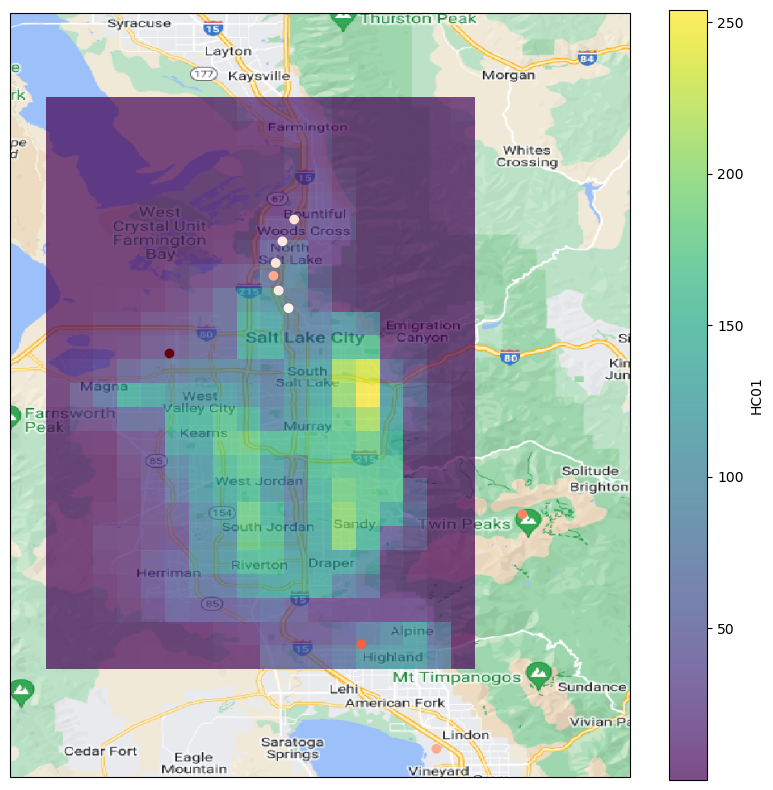

In [79]:
map_extent={'lon_min':-112.2,
        'lon_max':-111.55,
        'lat_min':40.3,
        'lat_max':41.1} 

dataset_extent = {'lon_min':-112.16,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 

var = 'HC01'

plotds = ncf.slice_extent(absolute_emissions[var].sum(dim = 'sector'),dataset_extent)
print(plotds.sum())

labsize = 12
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection = proj)
ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)

request = cimgt.GoogleTiles(style='street')
scale = 10.0 # prob have to adjust this
ax.add_image(request,int(scale))

plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis',alpha = 0.7)

ax.scatter(big_point['lon'],big_point['lat'],c = big_point['HC01'],cmap = 'Reds',transform = proj)

plt.show()

In [89]:
point_df['sector'].unique()

array(['point_EGU', 'point_Industry', 'point_OG', 'point_Other',
       'point_VCP'], dtype=object)

In [87]:
absolute_emissions['sector']

<xarray.DataArray 'sector' (sector: 8)>
array(['area_AG', 'area_Industry', 'area_OG', 'area_Other', 'area_VCP',
       'area_offroad', 'area_onroad_diesel', 'area_onroad_gasoline'],
      dtype=object)
Coordinates:
  * sector   (sector) object 'area_AG' ... 'area_onroad_gasoline'

In [ ]:
map_extent={'lon_min':-112.2,
        'lon_max':-111.55,
        'lat_min':40.3,
        'lat_max':41.1} 

dataset_extent = {'lon_min':-112.16,
                  'lon_max':-111.7,
                  'lat_min':40.4,
                  'lat_max':41.0} 

for area_sector in absolute_emissions['sector']:
    sector_tag = sector.split('_')[1]

    plotds = ncf.slice_extent(absolute_emissions['HC01'].sel(sector=area_sector),dataset_extent)
    point_plot_df = point_df[point_df['sector'] == f'point_{sector_tag}']

    labsize = 12
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection = proj)
    ax.set_extent([map_extent['lon_min'],map_extent['lon_max'],map_extent['lat_min'],map_extent['lat_max']],crs=proj)

    request = cimgt.GoogleTiles(style='street')
    scale = 10.0 # prob have to adjust this
    ax.add_image(request,int(scale))

    plotds.plot.pcolormesh('lon','lat',ax = ax,cmap = 'viridis',alpha = 0.7)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)
    plt.show()